In [2]:
import os
import numpy as np
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from skimage import io
import math
import cmath

In [3]:
def load_images(data_root='data'):
    """
    load image pixle values into numpy array
    the class labels are extracted from image name
    """
    image_files = os.listdir(data_root)
    image_np_dict = {
        'deer': [],
        'horse': [],
        'squirrel': [],
        'tiger': []
    }
    
    print('INFO: reading images..')
    for file in image_files:
        # print(f'INFO: reading image file: {file}')
        label = file.split('-')[0]
        img = io.imread(f'{data_root}/{file}', as_gray=True)
        # img = img / np.max(img)
        image_np_dict[label].append(img)

    # image_np_dict['deer'] = np.array(image_np_dict['deer'])
    # image_np_dict['horse'] = np.array(image_np_dict['horse'])
    # image_np_dict['squirrel'] = np.array(image_np_dict['squirrel'])
    # image_np_dict['tiger'] = np.array(image_np_dict['tiger'])
    class_labels = list(image_np_dict.keys())

    print('INFO: reading images complete')
    return image_np_dict, class_labels


# image_np_dict, class_labels = load_images()

In [4]:
def compute_fourier_space_features(coeff_data, feature_name):
    # compute spectral rotation angle
    def compute_phase_angle(z):
        phase = cmath.phase(z)
        return phase

    # Compute sector index
    def compute_sector(z):
        phase = cmath.phase(z)
        v = (phase_d/22.5)//1 #get only integer
        if v == 16:
            return 0
            
        return v

    # Compute distance given r,c
    def compute_distance(r, c):
        x = r - (N / 2)
        y = (N / 2) - c
        d = math.sqrt(x*x+y*y)
        return d

    computed_custom_features = []
    for z in coeff_data:
        r, c = z.real, z.imag
        if feature_name == 'angle':
            computed_custom_features.append(compute_rotation_angle(r, c))
            
        if feature_name == 'sector':
            computed_custom_features.append(compute_sector(r, c))
            
        if feature_name == 'distance':
            computed_custom_features.append(compute_distance(r, c))

    return computed_custom_features

In [5]:
def compute_fourier_coefficients_and_magnitude(image_np_dict):
    """
    1. compute fourier transformation for each image
    2. compute the magnitude of fourier coefficients
    """
    mag_np_dict = {
        'deer': [],
        'horse': [],
        'squirrel': [],
        'tiger': []
    }
    coefficients_np_dict = {
        'deer': [],
        'horse': [],
        'squirrel': [],
        'tiger': []
    }
    for label, data_list in image_np_dict.items():
        print(f'INFO: computing fourier coefficients of {label} data')
        for i, data in enumerate(data_list):
            # print(f'INFO: computing index: {i}')
            fourier_coefficients = np.fft.fftshift(np.fft.fft2(data))
            coefficients_np_dict[label].append(fourier_coefficients)
            magnitudes_np = abs(fourier_coefficients)
            # print(magnitudes_np)
            mag_np_dict[label].append(magnitudes_np)

    print('INFO: computing fourier coefficients complete')
    return coefficients_np_dict, mag_np_dict


# mag_np_dict = compute_fourier_magnitude(image_np_dict)

In [6]:
def flatten_and_sort_coefficients_and_magnitudes(coefficients_np_dict, mag_np_dict):
    """
    flatten and sort fourier coefficients and magnitudes
    """
    flatten_mag_dict = {
        'deer': [],
        'horse': [],
        'squirrel': [],
        'tiger': []
    }
    flatten_coeff_dict = {
        'deer': [],
        'horse': [],
        'squirrel': [],
        'tiger': []
    }

    for label, data_list in mag_np_dict.items():
        print(f'INFO: flattening and sorting {label} data')
        for i, data in enumerate(data_list):
            flatten_mag_data = data.flatten()
            flatten_coeff_data = coefficients_np_dict[label][i].flatten()
            sorted_indices = np.argsort(flatten_mag_data)[::-1]
            
            flatten_mag_data = flatten_mag_data[sorted_indices]
            flatten_mag_dict[label].append(flatten_mag_data)

            flatten_coeff_data = flatten_coeff_data[sorted_indices]
            flatten_coeff_dict[label].append(flatten_coeff_data)

    print('INFO: processing complete')
    return flatten_coeff_dict, flatten_mag_dict

# flatten_dict = flatten_and_sort_magnitudes(mag_np_dict)

In [7]:
def filter_flatten_data_by_max_value(flatten_dict, cutoff):
    """
    captured the fourier magnitude where magnitude >= cutoff
    """
    filtered_data_dict = {
        'deer': [],
        'horse': [],
        'squirrel': [],
        'tiger': []
    }

    for label, data_list in flatten_dict.items():
        print(f'INFO: filtering magnitude of {label} - cutoff: {cutoff}')
        for i, data in enumerate(data_list):
            items = []
            for n in data:
                if n >= cutoff:
                    items.append(n)
                    
            items = np.array(items)
            # print(f'INFO: total value count: {len(items)}')
            filtered_data_dict[label].append(items)

    print('INFO: processing complete')
    return filtered_data_dict


# filtered_data_dict = filter_flatten_data_by_max_value(flatten_dict, 5000)

In [8]:
def grip_first_n_items(mag_np_dict, limit):
    """
    capture first n magnitude values
    """
    gripped_data_dict = {
        'deer': [],
        'horse': [],
        'squirrel': [],
        'tiger': []
    }

    for label, data_list in mag_np_dict.items():
        print(f'INFO: gripping date of {label} - limit: {limit}')
        for i, data in enumerate(data_list):
            items = data[0:limit]
            print(f'INFO: total value count: {len(items)}')
            gripped_data_dict[label].append(items)

    print('INFO: processing complete')
    return gripped_data_dict


# gripped_data_dict = grip_first_n_items(flatten_dict, 100)

In [9]:
def get_normalized_n_data_samples(flatten_coeff_dict, flatten_mag_dict, sample_sizes, fs_features):
    """
    get multiple samples and apply normalization
    """
    n_samples = {}
    for size, dim in sample_sizes.items():
        sample_data_dict = {
            'deer': [],
            'horse': [],
            'squirrel': [],
            'tiger': []
        }
        print(f'INFO: sampling and normalizing - size: {size}')
        # sample = grip_first_n_items(gripped_data_dict, size)
        
        for label, data_list in flatten_mag_dict.items():
            for i, data in enumerate(data_list):
                mag_norm = data[0:size]
                mag_norm = mag_norm / np.max(mag_norm)
                mag_norm = mag_norm.reshape(dim)

                fft_features = [mag_norm]
                coeff_data = flatten_coeff_dict[label][i][0:size]
                
                # compute fourier space features
                for fs_feature in fs_features:
                    fft_features.append(compute_fourier_space_features(coeff_data, fs_feature))
                
                # print(mag_norm)
                # sample_data_dict[label].append(fft_features)
                sample_data_dict[label].append(mag_norm)
                
        n_samples[size] = sample_data_dict

    print('INFO: sampling and normalization complete')
    return n_samples


# n_samples = get_normalized_n_data_samples(gripped_data_dict, [500, 700, 1000, 1200, 1500, 2000, 2500, 3000])

In [10]:
"""def get_dataset_features_and_labels():
    """
    """
    print(f"{'-'*15} LOADING IMAGES {'-'*15}")
    image_np_dict, class_labels = load_images()
    
    print(f"{'-'*15} COMPUTE FOURIER COEFFICIENTS {'-'*15}")
    coefficients_np_dict, mag_np_dict = compute_fourier_coefficients_and_magnitude(image_np_dict)
    
    print(f"{'-'*15} FLATTEN AND SORT MAGNITUDE {'-'*15}")
    flatten_coeff_dict, flatten_mag_dict = flatten_and_sort_coefficients_and_magnitudes(coefficients_np_dict, mag_np_dict)

    print(f"{'-'*15} DATA SAMPLING {'-'*15}")
    sample_sizes = [
        500,
        1000,
        5000,
        10000,
        20000,
        50000,
        100000,
        500000,
        1000000
    ]
    custom_fourier_space_features = [
        'angle',
        'sector',
        'distance'
    ]
    n_samples = get_normalized_n_data_samples(flatten_coeff_dict, flatten_mag_dict, sample_sizes, custom_fourier_space_features)
    return n_samples

n_samples = get_dataset_features_and_labels()"""

IndentationError: unexpected indent (1357157345.py, line 3)

In [16]:
def get_dataset_features_and_labels():
    """
    """
    print(f"{'-'*15} LOADING IMAGES {'-'*15}")
    image_np_dict, class_labels = load_images()
    
    print(f"{'-'*15} COMPUTE FOURIER COEFFICIENTS {'-'*15}")
    coefficients_np_dict, mag_np_dict = compute_fourier_coefficients_and_magnitude(image_np_dict)
    
    print(f"{'-'*15} FLATTEN AND SORT MAGNITUDE {'-'*15}")
    flatten_coeff_dict, flatten_mag_dict = flatten_and_sort_coefficients_and_magnitudes(coefficients_np_dict, mag_np_dict)

    print(f"{'-'*15} DATA SAMPLING {'-'*15}")
    sample_sizes = {
        64: (8, 8),
        256: (16, 16),
        1024: (32, 32),
        4096: (64, 64),
        16384: (128, 128),
        65536: (256, 256),
        262144: (512, 512)
    }
    n_samples = get_normalized_n_data_samples(flatten_coeff_dict, flatten_mag_dict, sample_sizes, [])
    
    return {
        'n_samples': n_samples, 'image_np_dict': image_np_dict, 'class_labels': class_labels,
        'coefficients_np_dict': coefficients_np_dict, 'mag_np_dict': mag_np_dict,
        'flatten_coeff_dict': flatten_coeff_dict, 'flatten_mag_dict': flatten_mag_dict
    }

features_dict = get_dataset_features_and_labels()
n_samples = features_dict['n_samples']
image_np_dict = features_dict['image_np_dict']
mag_np_dict = features_dict['mag_np_dict']

--------------- LOADING IMAGES ---------------
INFO: reading images..
INFO: reading images complete
--------------- COMPUTE FOURIER COEFFICIENTS ---------------
INFO: computing fourier coefficients of deer data
INFO: computing fourier coefficients of horse data
INFO: computing fourier coefficients of squirrel data
INFO: computing fourier coefficients of tiger data
INFO: computing fourier coefficients complete
--------------- FLATTEN AND SORT MAGNITUDE ---------------
INFO: flattening and sorting deer data
INFO: flattening and sorting horse data
INFO: flattening and sorting squirrel data
INFO: flattening and sorting tiger data
INFO: processing complete
--------------- DATA SAMPLING ---------------
INFO: sampling and normalizing - size: 64
INFO: sampling and normalizing - size: 256
INFO: sampling and normalizing - size: 1024
INFO: sampling and normalizing - size: 4096
INFO: sampling and normalizing - size: 16384
INFO: sampling and normalizing - size: 65536
INFO: sampling and normalizing 

In [25]:
python -v

NameError: name 'python' is not defined

In [22]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
model

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
np.max(n_samples[500]['deer'][0])

In [41]:
np.min(flatten_dict['deer'][0])

0.004016516585697291

In [44]:
np.array([1,2,3,4]) > 2

array([False, False,  True,  True])

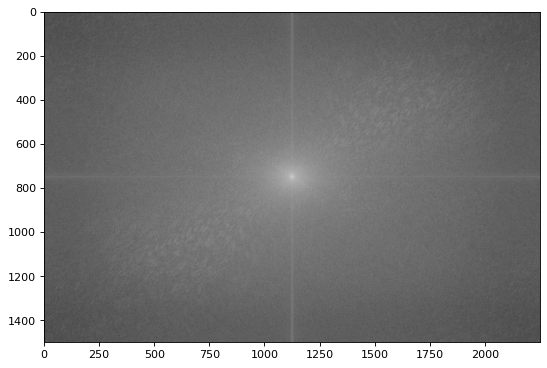

In [11]:
dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(image_np_dict['tiger'][0]))
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(np.log(abs(dark_image_grey_fourier)), cmap='gray')

In [48]:
dark_image_grey_fourier[0][0]

(-3.545450196078348+4.085620730620576e-14j)

In [52]:
abs(dark_image_grey_fourier).shape

(1500, 2250)

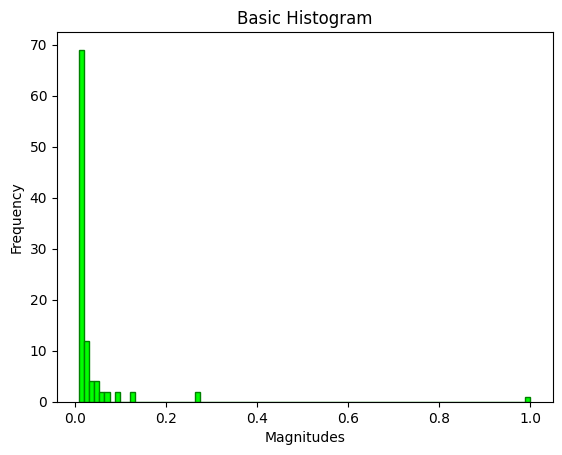

In [118]:
data = np.random.randn(1000)
 
# Plotting a basic histogram
plt.hist(n_samples[500]['deer'][0], bins=90, color='lime', edgecolor='green')
 
# Adding labels and title
plt.xlabel('Magnitudes')
plt.ylabel('Frequency')
plt.title('Basic Histogram')
 
# Display the plot
plt.show()

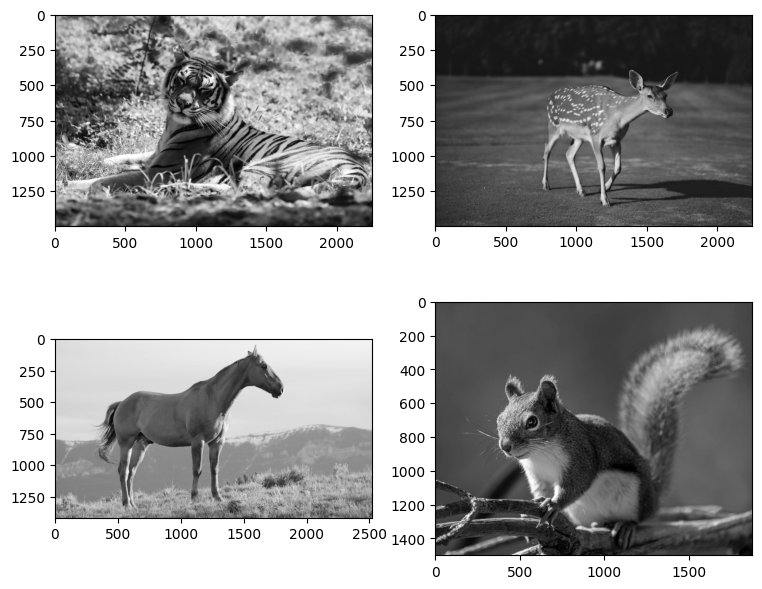

In [18]:
plt.rcParams["figure.figsize"] = (9,8)
f, axarr = plt.subplots(2, 2, gridspec_kw = {'hspace':0})
axarr[0,0].imshow(image_np_dict['tiger'][0], cmap='gray')
axarr[0,1].imshow(image_np_dict['deer'][0], cmap='gray')
axarr[1,0].imshow(image_np_dict['horse'][4], cmap='gray')
axarr[1,1].imshow(image_np_dict['squirrel'][0], cmap='gray')

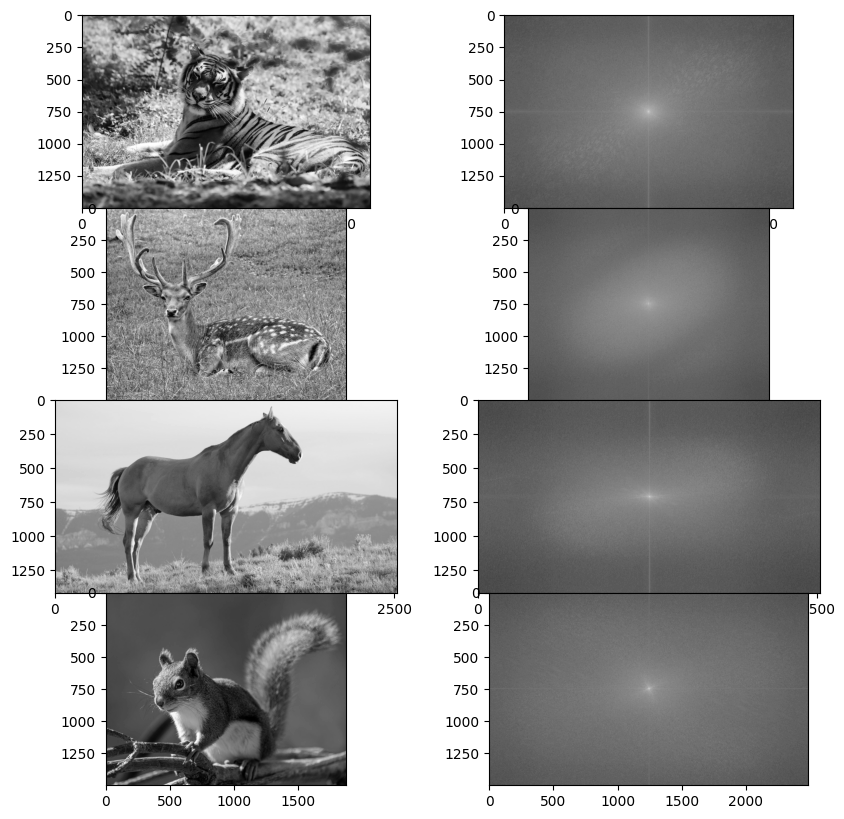

In [20]:
plt.rcParams["figure.figsize"] = (10,10)
f, axarr = plt.subplots(4, 2, gridspec_kw = {'hspace':0})
axarr[0,0].imshow(image_np_dict['tiger'][0], cmap='gray')
axarr[0,1].imshow(np.log(mag_np_dict['tiger'][0]), cmap='gray')
axarr[1,0].imshow(image_np_dict['deer'][4], cmap='gray')
axarr[1,1].imshow(np.log(mag_np_dict['deer'][4]), cmap='gray')
axarr[2,0].imshow(image_np_dict['horse'][4], cmap='gray')
axarr[2,1].imshow(np.log(mag_np_dict['horse'][4]), cmap='gray')
axarr[3,0].imshow(image_np_dict['squirrel'][0], cmap='gray')
axarr[3,1].imshow(np.log(mag_np_dict['squirrel'][1]), cmap='gray')

In [19]:
def read_and_process_image(file_path):
    # resize - 512x512
    orig_image = Image.open(file_path).resize((512, 512))
    orig_image_size = orig_image.size
    orig_image_size_in_kb = os.stat(file_path).st_size / 1024
    orig_image_data = orig_image.getdata()
    np_image_array = np.array(orig_image_data)
    # reshape - keep only height width and channel dimensions
    np_image_array = np_image_array.reshape(*orig_image.size, -1)
    # store data into dictionary
    image_data_dict = {
        'orig_image': orig_image,
        'orig_image_size': orig_image_size,
        'orig_image_data': orig_image_data,
        'np_image_array': np_image_array,
        'orig_image_size_in_kb': orig_image_size_in_kb
    }
    return image_data_dict